# Modélisation de bruit corrélé autour d'un modèle physique avec les processus gaussiens

Au dernier cours, nous avons vu comment implémenter une version simple des processus gaussiens.
Tel que vu en classe, un processus gaussien permet de modéliser le bruit corrélé autour d'un modèle paramétrique (souvent appelé "mean function" dans la littérature).
Nous allons effectuer une telle analyse avec un modèle physique assez similaire à celui utilisé dans le devoir 1.

Pour couvrir du même coup les GPs et le HMC, nous allons utiliser la librairie `tinygp`, qui utilise `jax` afin de facilement calculer le gradient des modèles GPs.
J'ai ajouté un notebook `tinygp.ipynb` dans le TP sur les processus gaussiens, qui pourra servir de référence.

Pour l'échantillonnage HMC, nous allons utiliser NumPyro, une librairie de programmation probabiliste (PPL).
Elle est aussi basée sur JAX.

## Définition du modèle physique

Supposons qu'on cherche l'amplitude, la largeur et la position d'une raie d'émission. On additionne aussi une constante pour modéliser le niveau du continuum. Notre modèle sera donc

$$
m(x) = b + a \exp{\left(-\frac{(x-\ell)^2}{2 w^2}\right)}
$$

Pour que le modèle soit compatible avec `tinygp` et NumPyro, nous allons le créer avec `jax`.

**Implémentez le modèle ci-dessus avec JAX (`jnp`). Utilisez un dictionnaire de paramètres comme premier argument et une valeur de $x$ comme deuxième argument.**

_Note: C'est un hasard qu'on utilise une **gaussienne** comme modèle paramétrique avec notre processus **gaussien**. La fonction paramétrique ("mean function") aurait pu être une droite, un sinus, un transit, etc., selon les données qu'on observe._

In [2]:
from functools import partial
from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# Précision machine "double" avec Jax
jax.config.update("jax_enable_x64", True)

plt.style.use("tableau-colorblind10")

def gaussian_model(params: dict, x: float):
    """
    Modèle d'une gaussienne et d'un terme constant.

    Paramètres
    ----------
    params : dict
        Dictionnaire de paramètres avec des éléments "loc", "log_width", "a" et "b".
    X : float
        Valeur(s) X pour laquelle on calcule la fonction.
    """
    # Le modèle de gaussienne
    mod = params["b"] + params["a"] * jnp.exp(-0.5 * jnp.square((x - params["loc"]) / jnp.exp(params["log_width"])))
    return mod

**Testez votre modèle avec des valeurs quelconques pour les paramètres.**

In [6]:
# TODO: Définir dictionnaire mean_params
X_grid = np.linspace(0, 10, num=200)
mean_params = {
    "a": 1.0,
    "b": 0.0,
    "log_width": jnp.log(1.0),
    "loc": 5.0,
}

ymodel = gaussian_model(mean_params, X_grid)

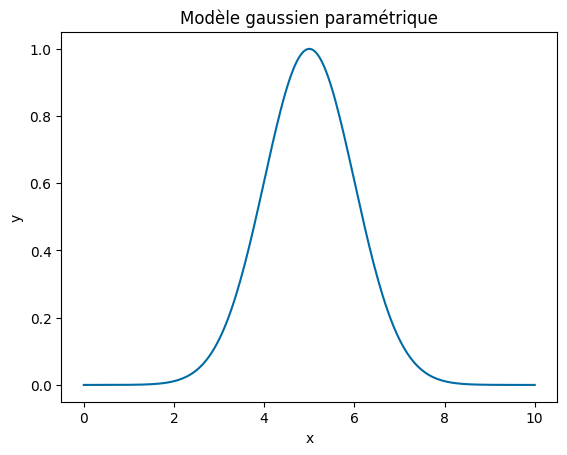

In [7]:
plt.plot(X_grid, ymodel)
plt.title("Modèle gaussien paramétrique")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Données simulées
On peut générer des données simulées à partir de la gaussienne, mais aussi d'un signal additionnel "inconnu" qu'on pourra modéliser avec un GP.

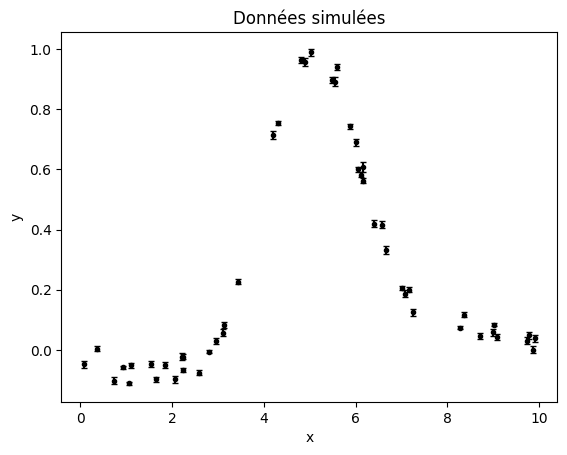

In [14]:
random = np.random.default_rng(135)
X = np.sort(random.uniform(0, 10, 50))
X_test = np.linspace(X.min() - 2.0, X.max() + 2.0, num=200)
y = gaussian_model(mean_params, X)
true_y = gaussian_model(mean_params, X_test)
y += 0.1 * np.sin(2 * np.pi * (X - 5) / 10.0)
true_y += 0.1 * np.sin(2 * np.pi * (X_test - 5) / 10.0)
y += 0.03 * random.normal(size=len(X))
yerr = np.abs(0.003 * random.normal(size=len(X)) + 0.01)

plt.errorbar(X, y, yerr, fmt="k.", capsize=2)
plt.title("Données simulées")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Modèle GP

Il est maintenant temps de définir le modèle GP que nous allons utiliser pour les données.
La fonction "moyenne" reste la même (une gaussienne), mais on ajoute un GP à notre modèle pour s'occuper du signal additionnel.
On utilise un kernel Matérn-5/2. En partique, on en testerait probablement quelques uns pour vérifier que le choix est optimal.

On construit le GP dans une fonction afin de facilement mettre à jour les paramètres à chaque itération d'un optimiseur ou d'un MCMC.

**Définissez une fonction `build_gp` qui retourne un objet `tinygp.GaussianProcess`.**
**Référez vous aux annotations pour les détails concernant les paramètres.**
**Assurez-vous de bien convertir les paramètres donnés en échelle log via `jnp.exp`.**


In [19]:
from tinygp import kernels, GaussianProcess

def build_gp(
        params: dict, X: Union[np.ndarray, jax.Array], yerr: Union[np.ndarray, float, jax.Array] = 0.0
) -> GaussianProcess:
    """
    Création d'un modèle GP

    Paramètres
    ----------
    params : dict
        Paramètres du modèle dans un dictionnaire. Devrait contenir les paramètres log_gp_amp, log_gp_scale et log_gp_diag, en plus des paramètres pour gaussian_model()
    X : Union[np.ndarray, jax.Array]
        Coordonnées d'entrée X du GP pour le calcul de la vraisemblance
    yerr: Union[np.ndarray, float, jax.Array]
        Erreur sur les mesures. Le carré des erreurs est ajouté à la diagonale.
        Pour générer des échantillons du GP. ce paramètre devrait être 0.0
    """
    kernel = jnp.exp(params["log_gp_amp"]) * kernels.Matern52(
        jnp.exp(params["log_gp_scale"])
    )
    
    return GaussianProcess(kernel, X, diag=yerr**2 + jnp.exp(params["log_gp_diag"]), mean=lambda x: gaussian_model(params, x))


### Distribution _prior_ du GP

On peut d'abord vérifier de quoi on l'air les échantillons individuels du GP _à priori_, avant d'avoir montré des données au modèle.

In [20]:
params_ini = {
    "log_gp_amp": np.log(0.1),
    "log_gp_scale": np.log(3),
    # Petite valeur pour afficher des prédictions qui ne tiennent pas compte de données.
    # Si on utilisait une grande valeur, il y aurait un bruit "blanc" (gaussien indépendant) sur chacun des points dans l'échantillon prior.
    "log_gp_diag": np.log(1e-8),
    "a": 0.2,
    "b": 0.1,
    "loc": 4.5,
    "log_width": np.log(1.0),
}

**Créez un objet `gp` avec `build_gp` et affichez 10 échantillons du prior pour `X_test`.**

(10, 200)


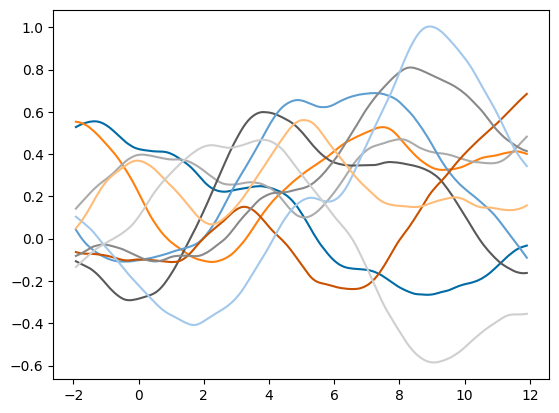

In [21]:
gp = build_gp(params_ini, X_test)

gp_prior_samples = gp.sample(jax.random.key(8), shape=(10,))
print(gp_prior_samples.shape)

plt.plot(X_test, gp_prior_samples.T)
plt.show()

On peut également vérifier de quoi ont l'air la moyenne et la variance du GP.

**Copiez le graphique ci-dessus, mais ajoutez la moyenne et l'intervalle $1~\sigma$ du GP.**

In [ ]:
# TODO: plot with GP mean and sigma

On voit que le prior du GP est très incertain autour de la moyenne. En montrant des données au GP, la situation devrait s'améliorer un peu.

### GP conditionné (_posterior_)

Maintenant, _sans modifier les hyperparamètres_, on peut conditionner le GP sur les données. Mêmes si les hyperaparamètres ne sont pas optimaux, on devrait au moins obtenir une prédiction qui ne passe pas trop loin des données.

**Utilisez `build_gp` pour générer un GP sur les données `X`. Tenez aussi compte de l'erreur `yerr` sur les observations.**

In [22]:
# Ajout d'un terme de diagonale, qu'on avait initialisé à 0 pour tirer des échantillons
params_ini["log_gp_diag"] = np.log(0.001)
gp = build_gp(params_ini, X, yerr=yerr)

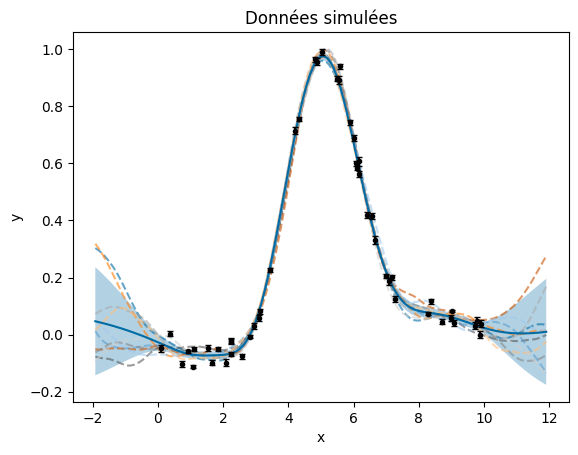

In [28]:
gp_posterior_samples = cond_gp.sample(jax.random.key(8), shape=(10,))

plt.plot(X_test, gp_posterior_samples.T, alpha=0.6, linestyle="--")
plt.plot(X_test, cond_gp.mean)
plt.fill_between(X_test, cond_gp.mean - np.sqrt(cond_gp.variance), cond_gp.mean + np.sqrt(cond_gp.variance), alpha=0.3)
plt.errorbar(X, y, yerr, fmt="k.", capsize=2)
plt.title("Données simulées")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.show()

**Conditionnez ensuite le GP sur les observations `y`. On veut générer la prédiction sur `X_test`.**

Déjà beaucoup mieux. Le modèle passe maintenant plus près des données. L'incertitude est également contrainte.
Par contre, on peut tout de même noter un petite écart dans le pic de la gaussienne. Et les échantillons oscillent un peu rapidement, faisant perdre de la capacité d'extrapolation.
De meilleurs hyperparamètres devraient améliorer la situation.

## Optimisation avec Jaxopt

Il existe plusieurs librairies d'optimisation avec Jax. Ici, on utilise Jaxopt.
Comme Jax calcule automatiquement les gradients, on peut tirer avantage des algorithmes d'optimisation avec gradient.

On doit d'abord définir une "loss function", que l'on souhaite minimiser. Il s'agit ici de la vraisemblance négative (toujours en log).

**Utilisez jaxopt pour optimiser le modèle**.

In [ ]:
import jaxopt

# TODO: Définir une fonction "loss" et optimiser avevc jaxopt

On peut ensuite chercher le minimum avec une interface similaire à scipy.

Regardons maintenant de quoi a l'air notre modèle conditionné sur les données, avec les nouveaux hyperparamètres.

In [ ]:
gp = build_gp(soln.params, X, yerr)
_, cond = gp.condition(y, X_test)

mu = cond.loc
std = np.sqrt(cond.variance)
samp = cond.sample(jax.random.PRNGKey(33), shape=(5,))

plt.plot(X_test, mu, label="Modèle")
plt.plot(X_test, true_y, "k", lw=1.5, alpha=0.3, label="Signal simulé")
plt.fill_between(X_test, mu + std, mu - std, color="C0", alpha=0.3)
plt.plot(X_test, samp.T)
plt.errorbar(X, y, yerr, fmt="k.", capsize=2)
plt.xlim(X_test.min(), X_test.max())
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Pas si mal! Par contre, difficile de voir ce qui vient du GP et ce qui vient de notre modèle gaussiens... Pour ce faire, on peut séparer les contributions de chaque terme.

In [ ]:
gp = build_gp(soln.params, X, yerr)
_, cond = gp.condition(y, X_grid, include_mean=False)

mu = cond.loc + soln.params["b"]
std = np.sqrt(cond.variance)

plt.errorbar(X, y, yerr=yerr, fmt="k.", label="Données", capsize=2)
plt.plot(X_grid, mu, label="Modèle GP")
plt.fill_between(X_grid, mu + std, mu - std, color="C0", alpha=0.3)
plt.plot(X_grid, jax.vmap(gp.mean_function)(X_grid), label="Model moyen (gaussienne)")

plt.xlim(X_grid.min(), X_grid.max())
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## HMC avec Numpyro

Comme JAX nous donne automatiquement les gradients, il existe plusieurs librairies pour tirer avantage du HMC avec JAX.
L'une des plus communes est NumPyro, qui implémente plusieurs distribution et simplifie beaucoup la définition d'un modèle probabiliste.

In [29]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

/home/vandal/miniforge3/envs/phy3051/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
# Utiliser 2 CPUs pour le MCMC (1 par chaîne)
numpyro.set_host_device_count(2)

def numpyro_model(X, yerr, y=None):
    # Definition de nos paramètres (priors).
    # Comme notre modèle utilise un dictionnaire, on place les distribution dans un dictionnaire
    params = dict(
        log_gp_amp = numpyro.sample("log_gp_amp", dist.Uniform(jnp.log(1e-4), jnp.log(1))),
        log_gp_scale = numpyro.sample("log_gp_scale", dist.Uniform(np.log(1e-4), np.log(1e2))),
        log_gp_diag = numpyro.sample("log_gp_diag", dist.Uniform(np.log(1e-4), np.log(1))),
        a = numpyro.sample("a", dist.LogUniform(1e-4, 10)),
        b = numpyro.sample("b", dist.Uniform(-0.1, 0.5)),
        loc = numpyro.sample("loc", dist.Uniform(0, 10)),
        log_width = numpyro.sample("log_width", dist.Uniform(np.log(1e-1), np.log(10.0))),
        
    )

    # Définition du modèle GP en incluant les priors
    gp = build_gp(params, X, yerr)

    # Ceci fait office de likelihood. Tinygp implémente directement une distribution numpyro
    # En utilisant "obs=y", on échantillonne selon les observations.
    #numpyro.sample("obs", dist.Normal(ymodel, yerr), obs=y)
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    # Il est intéressant de regarder la prédiction du GP à travers le sampling
    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, X_test).gp.loc)

In [31]:
# Numpyro utilise un "kernel" pour le MCMC, i.e. pour définir les propositions, un peu comme les "moves" emcee.
# Ici on utilise le No U-Turn Sampling, la version la plus commune du HMC.
# On lance le MCMC avec 1000 warm-up (burn in) et 1000 échantillons. On utilise 2 chaines (2 walkers dans emcee). Par contre ici les chaines sont indépendantes.
# TODO: MCMC definition
nuts_kernel = NUTS(model=numpyro_model, dense_mass=True, target_accept_prob=0.9)

In [32]:
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=2, progress_bar=True)

In [33]:
# Avec Jax, il faut générer explicitement les nombres aléatoires
# TODO: Run MCMC
mcmc.run(jax.random.key(344), X, yerr, y=y)

Compiling.. :   0%|                                              | 0/2000 [00:00<?, ?it/s]
%|                                                            | 0/2000 [00:00<?, ?it/s]
Running chain 0: 100%|████████████████████████████████| 2000/2000 [00:22<00:00, 87.14it/s]

Running chain 1: 100%|████████████████████████████████| 2000/2000 [00:41<00:00, 48.70it/s]


In [34]:
# On va ensuite chercher les échantillons
samples = mcmc.get_samples()
pred = samples["pred"]

In [35]:
samples

{'a': Array([0.97243635, 1.00378324, 1.02515519, ..., 1.04096005, 1.03220761,
        1.0034918 ], dtype=float64),
 'b': Array([ 0.08386669, -0.02609436, -0.03153329, ..., -0.01485319,
        -0.0123998 , -0.00768816], dtype=float64),
 'loc': Array([4.9943785 , 5.1146166 , 5.04082676, ..., 4.90831693, 4.91464994,
        4.94701038], dtype=float64),
 'log_gp_amp': Array([-3.62730509, -6.82997247, -6.1130621 , ..., -3.33285026,
        -3.64041994, -4.02514413], dtype=float64),
 'log_gp_diag': Array([-7.52177999, -6.62543894, -6.54466709, ..., -7.41034679,
        -7.33519524, -7.20803611], dtype=float64),
 'log_gp_scale': Array([1.30289644, 0.37417414, 1.49951398, ..., 1.09637285, 0.92284482,
        0.72404941], dtype=float64),
 'log_width': Array([ 0.02152101,  0.01240186,  0.0406141 , ..., -0.02866008,
        -0.02724033, -0.0377466 ], dtype=float64),
 'pred': Array([[ 0.03038747,  0.02868281,  0.02693532, ...,  0.00038361,
          0.00050708,  0.00069573],
        [-0.0267293 ,

Le MCMC est terminé. On a tout ce dont on a besoin pour estimer l'incertitude sur le GP.

### Visualisation

La librairie arviz permet de visualiser facilement un résumé des résultats et les statistiques associées.

In [36]:
import arviz as az

In [37]:
idata = az.from_numpyro(mcmc)

In [38]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [39]:
az.summary(idata, var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.011,0.062,0.891,1.121,0.002,0.002,1019.0,794.0,1.01
b,0.015,0.080,-0.099,0.149,0.003,0.002,791.0,488.0,1.00
loc,5.039,0.041,4.963,5.117,0.001,0.001,1511.0,961.0,1.01
log_gp_amp,-4.655,1.212,-6.635,-2.164,0.043,0.031,902.0,913.0,1.00
log_gp_diag,-7.159,0.250,-7.616,-6.698,0.006,0.004,1615.0,1328.0,1.00
...,...,...,...,...,...,...,...,...,...
pred[195],-0.004,0.020,-0.041,0.031,0.001,0.001,986.0,1168.0,1.01
pred[196],-0.005,0.021,-0.045,0.030,0.001,0.001,978.0,1168.0,1.01
pred[197],-0.005,0.022,-0.047,0.031,0.001,0.001,969.0,1102.0,1.01
pred[198],-0.006,0.022,-0.047,0.034,0.001,0.001,962.0,1102.0,1.01


Le "trace plot" montre les chaînes et la distribution poru chaque paramètre.

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'loc'}>, <Axes: title={'center': 'loc'}>],
       [<Axes: title={'center': 'log_gp_amp'}>,
        <Axes: title={'center': 'log_gp_amp'}>],
       [<Axes: title={'center': 'log_gp_diag'}>,
        <Axes: title={'center': 'log_gp_diag'}>],
       [<Axes: title={'center': 'log_gp_scale'}>,
        <Axes: title={'center': 'log_gp_scale'}>],
       [<Axes: title={'center': 'log_width'}>,
        <Axes: title={'center': 'log_width'}>]], dtype=object)

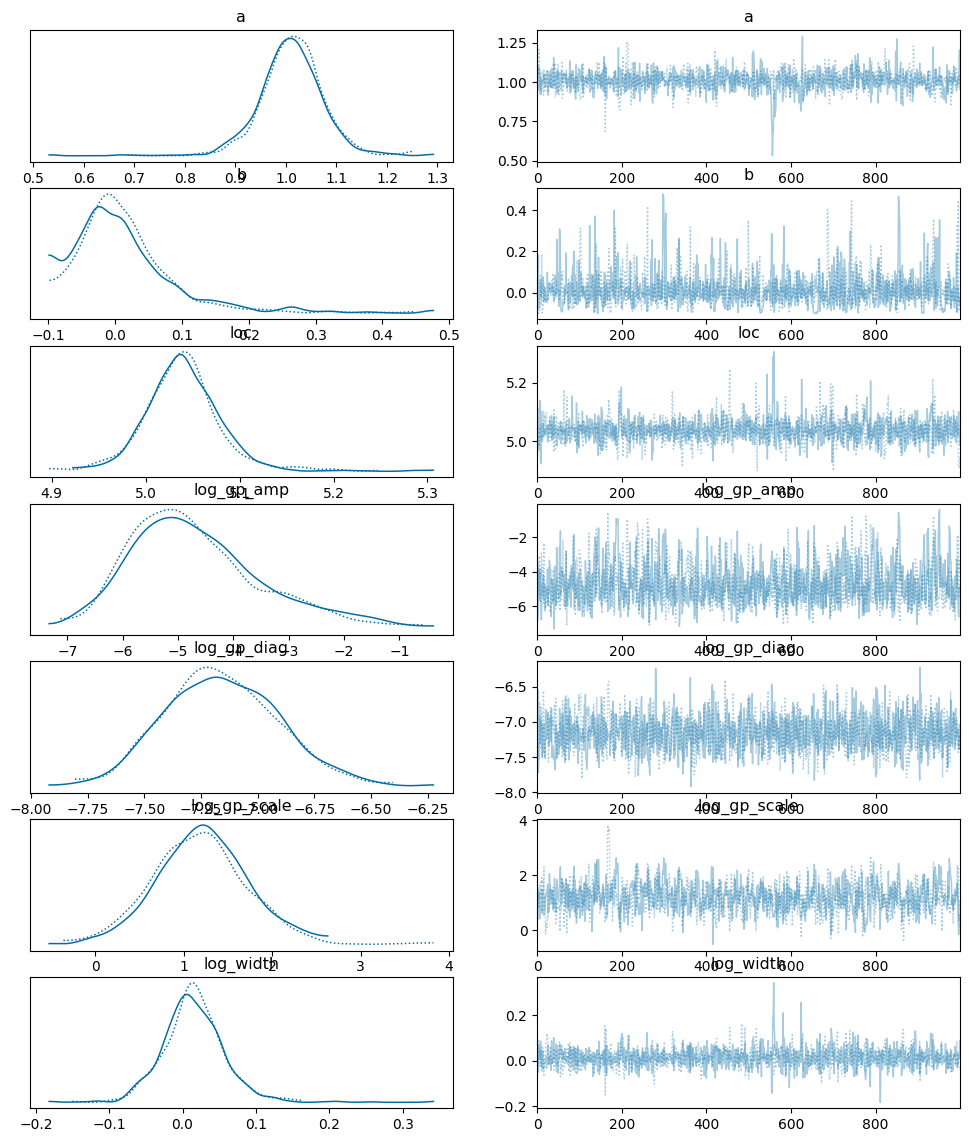

In [42]:
az.plot_trace(idata, var_names=[v for v in idata.posterior.data_vars if v != "pred"])

In [44]:
var_names=[v for v in idata.posterior.data_vars if v != "pred"]
mean_params = {
    "a": 0.3,
    "b": 0.1,
    "loc": 5.0,
    "log_width": np.log(0.5),
}
true_params = {name: mean_params.get(name) for name in var_names}

Corner est compatible avec numpyro et arviz.

In [45]:
import corner

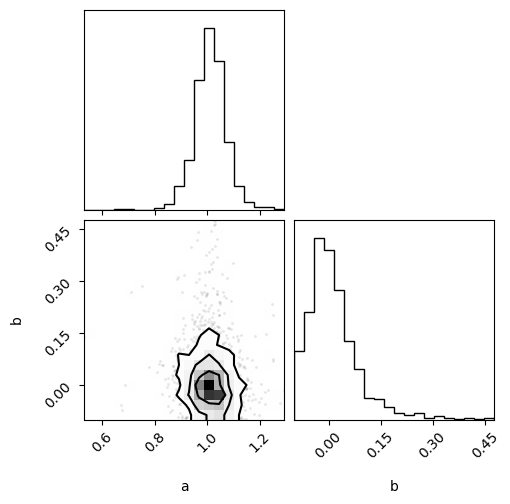

In [47]:
corner.corner(idata, var_names=["a", "b"])
plt.show()

Arviz donne aussi l'autocorrélation.

In [ ]:
az.plot_autocorr(
    data, var_names=[v for v in data.posterior.data_vars if v != "pred"]
)
plt.show()

On peut utiliser les quantiles du MCMC pour voir l'impact de l'incertitude sur les hyperparamètres.

In [ ]:
# TODO: Plot MCMC samples/quantiles